# Ultimate data challenge

## Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.



In [284]:
# load libraries
import pandas as pd
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar # get holidays
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np

import shap

In [205]:
# load Json data


logins = pd.read_json('logins.json')



logins.head()

#logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [206]:
#aggregate into 15 minute timepoints

In [207]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [208]:
logins.set_index("login_time", inplace=True)

logins['frequency']= 1

In [209]:
# bucket by 5 minutes
logins_15min = logins.resample("15min").sum()
logins_15min.reset_index(inplace=True)

logins_15min.head()



,login_time,frequency
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [210]:
login_features=logins_15min

In [211]:
#calculate day of week number (0 = Monday, 6= Sunday)
login_features['day_of_week']=login_features['login_time'].dt.day_of_week

# designate weekend ()
login_features.loc[login_features['day_of_week'] >=5, 'weekend'] = 1 
login_features.loc[login_features['day_of_week'] <5, 'weekend'] = 0 


# mark American holidays. Note that holidays that fall on weekedns are applied in the preceding or proceeding week.


cal = calendar()
holidays = cal.holidays(start=login_features['login_time'].min(),
                        end=login_features['login_time'].max()).to_pydatetime()

#designate which days are holidays
login_features['holiday'] = login_features['login_time'].isin(holidays)

login_features['hour']=login_features['login_time'].dt.hour



#check that tables look good by printing the first few rows.
login_features.head()

,login_time,frequency,day_of_week,weekend,holiday,hour
0,1970-01-01 20:00:00,2,3,0.0,False,20
1,1970-01-01 20:15:00,6,3,0.0,False,20
2,1970-01-01 20:30:00,9,3,0.0,False,20
3,1970-01-01 20:45:00,7,3,0.0,False,20
4,1970-01-01 21:00:00,1,3,0.0,False,21


In [212]:
login_features.describe()

,frequency,day_of_week,weekend,hour
count,9788.000000,9788.000000,9788.000000,9788.000000
mean,9.515938,3.035554,0.294238,11.496935
std,8.328818,2.012722,0.455723,6.922294
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,5.000000
50%,7.000000,3.000000,0.000000,11.000000
75%,13.000000,5.000000,1.000000,17.000000
max,73.000000,6.000000,1.000000,23.000000


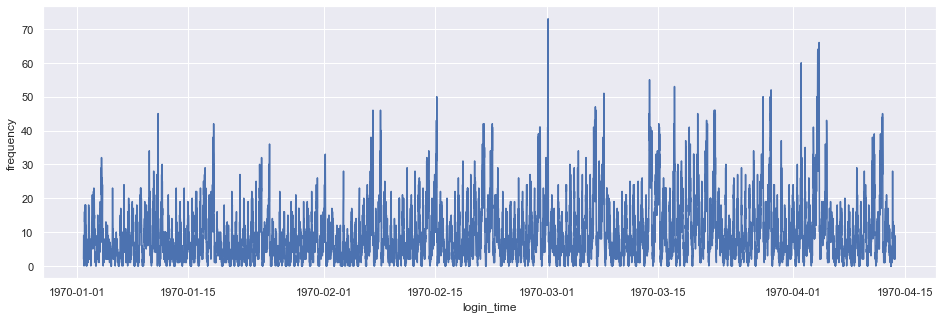

In [213]:
# create time series plots
import seaborn as sns
sns.lineplot(data=login_features, x="login_time", y="frequency")
sns.set(rc = {'figure.figsize':(16,5)})

<AxesSubplot:xlabel='day_of_week', ylabel='frequency'>

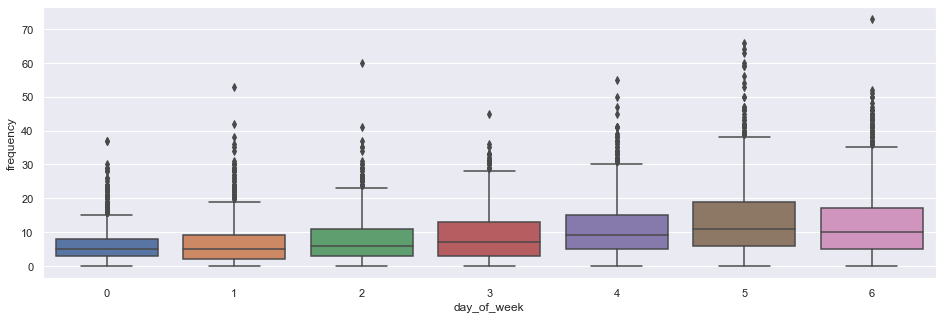

In [214]:
# boxplots
sns.boxplot(data=login_features, x="day_of_week", y="frequency")



<AxesSubplot:xlabel='hour', ylabel='frequency'>

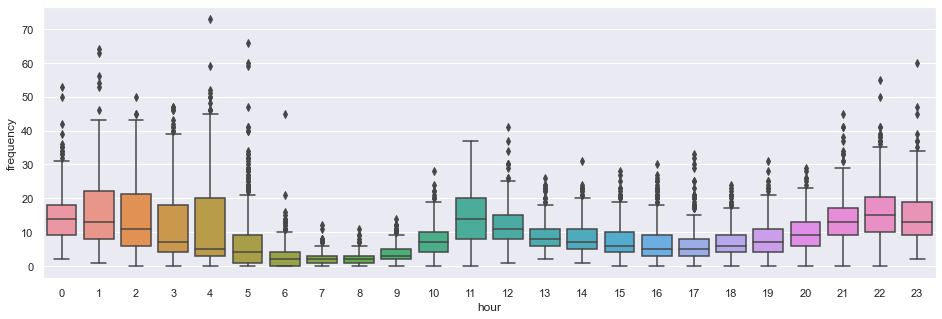

In [215]:
sns.boxplot(data=login_features, x="hour", y="frequency")


<AxesSubplot:xlabel='weekend', ylabel='frequency'>

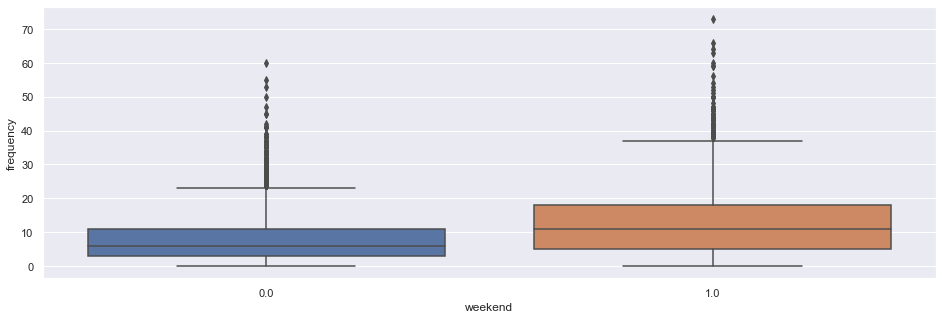

In [216]:
sns.boxplot(data=login_features, x="weekend", y="frequency")


<AxesSubplot:xlabel='holiday', ylabel='frequency'>

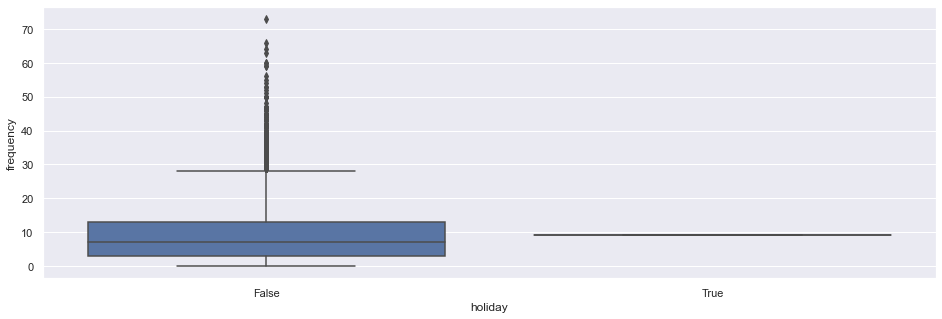

In [217]:
sns.boxplot(data=login_features, x="holiday", y="frequency")


In [218]:
all_hours_day_df = pd.pivot_table(data= login_features[['frequency', 'day_of_week', 'hour']], 
                                  values="frequency",
                                   index="day_of_week",
                                  columns="hour",
                                  margins=True
                                 )
                                  
# averages for pickups in 15min intervals by hour and day of week                                   )
all_hours_day_df.head()

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,All
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,8.850000,6.900000,5.200000,3.933333,3.433333,2.016667,1.100000,1.850000,2.450000,4.266667,...,4.883333,4.150000,3.966667,4.450000,4.678571,6.714286,10.803571,10.910714,9.500000,6.213380
1,10.839286,10.107143,7.035714,3.535714,2.660714,2.017857,0.821429,1.142857,1.571429,4.321429,...,4.410714,3.910714,3.267857,5.410714,5.375000,8.714286,12.571429,13.535714,12.928571,6.895833
2,12.267857,12.250000,8.607143,5.339286,4.375000,2.410714,0.857143,1.500000,1.767857,4.285714,...,4.696429,3.821429,3.428571,5.125000,5.464286,8.928571,13.196429,15.803571,16.214286,7.692708
3,14.571429,13.875000,11.160714,6.696429,4.553571,2.428571,1.196429,1.446429,1.696429,4.482143,...,5.000000,4.321429,4.142857,6.267857,7.000000,10.366667,14.500000,18.150000,17.216667,8.794118
4,16.250000,15.950000,12.850000,8.366667,5.883333,4.083333,2.016667,1.750000,1.816667,4.000000,...,6.500000,6.200000,8.000000,9.616667,10.966667,13.383333,20.100000,25.316667,21.633333,10.561111


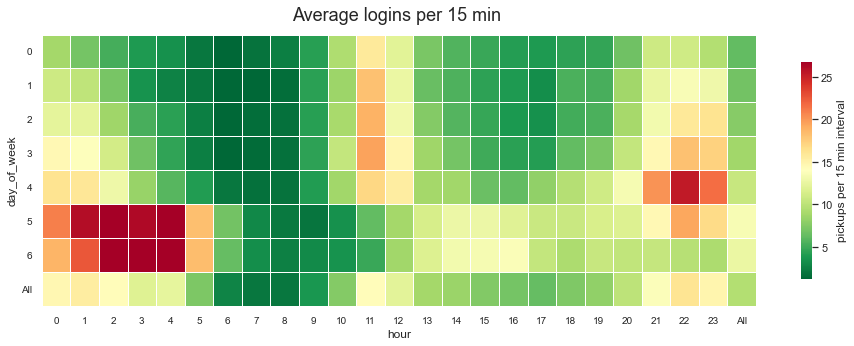

In [219]:
# Plot mean 15 min pickups per 15min intervals

ax = sns.heatmap(all_hours_day_df, cmap='RdYlGn_r',
                 robust=True,
                 fmt='.2f',
                 annot=False,
                 linewidths=.5,
                 annot_kws={'size':8},
                 cbar_kws={'shrink':.8,
                           'label':'pickups per 15 min interval'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Average logins per 15 min ', fontdict={'fontsize':18},    pad=14);

## Observations

User login data were analyzed for a 3 month period in the Winter and Spring of 1970.
logins were aggregated into 15 minute intervals.  Logins are highly cyclical as a function of the time of day and day of week. The highest average frequency during the week is around lunch (11:00-12:00) and in the late evening (10:00-2:00). On Friday evening there's a surge at 10:00 pm and a high number of rides in the early  morning until about 5:00 am.  Overall data seem in good shape despite some extreme weekend values. 

## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
### 1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The purpose of this experiment is to examine what effect lifting the tolls will have on drivers choosing to operate in either city. On weekdays the two cities have inverted schedules that create surplus capacity at night in Metropolis that is needed in Gotham and surplus capacity during the day in Gotham that could be used in Metropolis.  The hypothesis is that drivers are typically staying in their own city due to tolls on connecting bridges.  It is feasible that there are multiple barriers to entry that limit dual-city drivers.

The key measure for this experiment should be the proportion or total number of drivers who modify their behavior and service both cities.  This measurment isn't senstive to the total fares or total miles driven but instead will allow the team to isolate the effect of the toll on driver behavior.


### 2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

#### a) how you will implement the experiment

In order to isolate the effect of tolls have on driver behavior we propose a randomized control test with two groups.   We are interested in understanding the effect of tolls on driver behavior.  The experiment requires that we randomly divide a proportion of app users into two groups. 
1. The first group will be our control, they will be offered riders in both their town and across the bridge.  The two offered drivers will be similar driving times away to control for a preference for proximity.  This group won't be reimbursed for tolls.

2. The second group similar to the the first group will be offered riders in both their town and across the bridge.  The two offered drivers will be similar driving times away to control for a preference for proximity.  This group will be reimbursed for tolls.

The experiment would need to be run across multiple times of day and days of the week to control for the inverted patterns in peak travel for the two cities.


#### b) what statistical test(s) you will conduct to verify the significance of theobservation

We would track the proportion of users in each group that opted to cross the bridge in the control (A) and the test (B) group.  We are interested in determining if the test repsonse is higher or lower on average so we will conduct a two-sided t-test.  We are concerned about falsely rejecting the null hypothesis and recommend an alpha of .02.
The hypothesis of our study is that the test group that is compensated for tolls will have a greater proportion of drivers opt to cross-over the bridge to the other city and that this difference will have a p-value <.02.

#### c) how you would interpret the results and provide recommendations to the city operations team along with any caveats
If the randomized control test determines that the test group indeed travelled over the bridge more frequently we can conclude that the toll did provide a barrier.  In this case the company can evaluate the economics of providing toll vouchers. It is possible that the company could recoup the cost of tolls by gaining a larger proportion of market share in the opposite city.

If we fail to reject the null hypothesis than we cannot conclude that the toll is the cause of drivers opting to remain on one side of the bridge. it is possible that other reasons could be influencing the decision. For example, driver familiarity with each city, scheduling ocnstraints for other commitments, or a bias for local rides.  These other caveats can be evaluated with additional testing if there's a business justification.


# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?


2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.



3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

## Cleaning and Data prep

In [220]:
trips = pd.read_json('ultimate_data_challenge.json')
trips.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [221]:

# check data types
trips.info()
# check missing
print(trips.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
city                         0
trips_in_first_30_days       0
signup_date     

<AxesSubplot:>

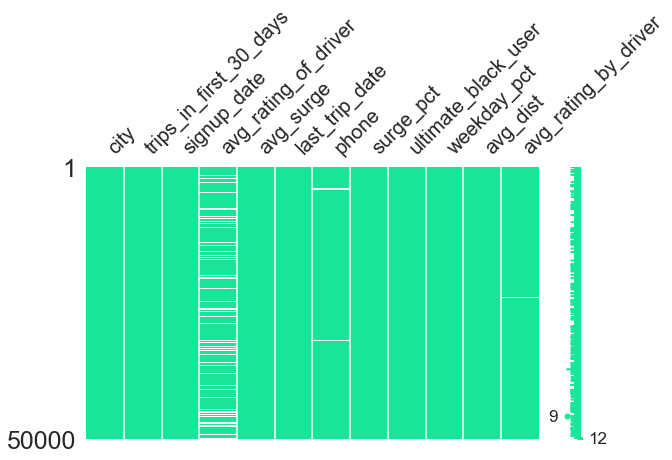

In [222]:
import missingno as msno
%matplotlib inline
msno.matrix(trips.sort_values('signup_date'), fontsize=20, figsize=(9,5), color=(0.1, 0.9, .6))

### Initial data observations
1. 50k rows of data mostly complete
2. "Avg rating of driver is missing at random"


### Data cleaning to perform:
    1. Convert "signup date" and "last trip date" to timestamp
    2. Mean impute "avg_rating_of_driver" and "avg_rating_by_driver"
    3. calculate month of signup
    4. calculate month of last ride
    5. create column of "rider" tenure. Time between sig up and last ride in days
    6. calculate "retention"
    impute with iphone
  

<AxesSubplot:xlabel='avg_rating_of_driver', ylabel='Count'>

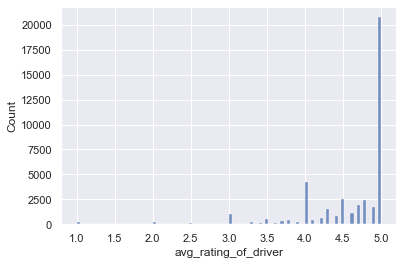

In [223]:
sns.histplot(x="avg_rating_of_driver", data=trips)

<AxesSubplot:xlabel='city', ylabel='count'>

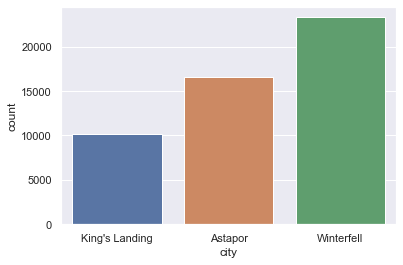

In [224]:
sns.countplot(x="city", data=trips)

<AxesSubplot:xlabel='phone', ylabel='count'>

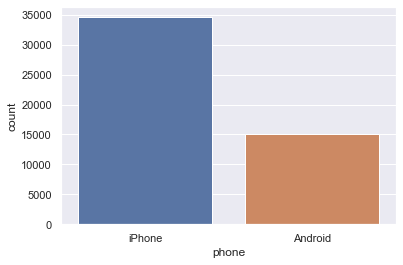

In [225]:
sns.countplot(x="phone", data=trips)

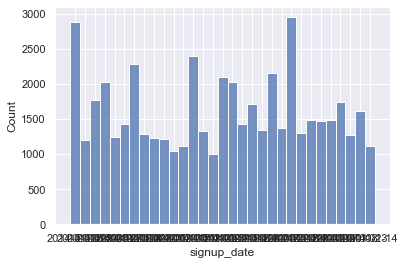

In [226]:
sns.histplot(x="signup_date", data=trips)
sns.set(rc={'figure.figsize':(14,5)})


<AxesSubplot:xlabel='last_trip_date', ylabel='Count'>

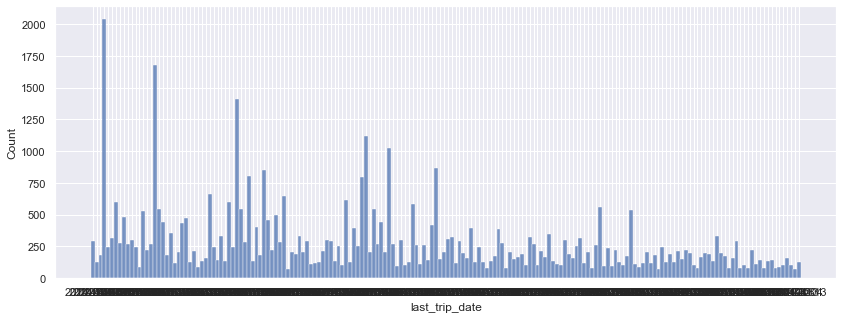

In [227]:
sns.histplot(x="last_trip_date", data=trips)

In [228]:
trips['last_trip_date'].sort_values().tail()

#retained individuals are retained if they used since 2014-06-01

45126    2014-07-01
38651    2014-07-01
14473    2014-07-01
22735    2014-07-01
45357    2014-07-01
Name: last_trip_date, dtype: object

In [243]:

# check data types
trips_cleaned= trips

# convert to datetime
trips_cleaned["signup_date"] =  pd.to_datetime(trips_cleaned["signup_date"], format="%Y-%m-%d")
trips_cleaned["last_trip_date"] =  pd.to_datetime(trips_cleaned["last_trip_date"], format="%Y-%m-%d")


# mean impute "avg_rating_of_driver" and "avg_rating_by_driver"
# distribution is skewed, opting for "median" imputation
trips_cleaned['avg_rating_of_driver'].fillna(int(trips_cleaned['avg_rating_of_driver'].median()), inplace=True)
trips_cleaned['avg_rating_by_driver'].fillna(int(trips_cleaned['avg_rating_by_driver'].median()), inplace=True)


# create month and year for signup date and last trip date
trips_cleaned['signup_month']=trips_cleaned['signup_date'].dt.month
trips_cleaned['last_trip_month']=trips_cleaned['last_trip_date'].dt.month

# calculate rider tenure (difference in last ride and first ride)
trips_cleaned['rider_tenure'] = trips_cleaned['last_trip_date'] - trips_cleaned['signup_date']

from datetime import timedelta

# retained

trips_cleaned['retained']= (trips_cleaned['last_trip_date'] > '2014-06-01')*1
trips_cleaned['retained'] = trips_cleaned['retained'].astype(int)    
#trips_cleaned['retained'] = trips_cleaned['retained'].astype("category")   

    
#trips_cleaned['rider_tenure']=trips_cleaned['rider_tenure']
trips_cleaned['rider_tenure']=trips_cleaned['rider_tenure'].astype('timedelta64[D]')

#randomly impute Phone column
trips_cleaned.loc[trips_cleaned["phone"].isna(), "phone"] = trips_cleaned["phone"].dropna().sample(
     trips_cleaned["phone"].isna().sum(),
     replace=True).values


#ultimate_black_user, change to integer
trips_cleaned['ultimate_black_user'] = trips_cleaned['ultimate_black_user'].astype(int)    



# check missing
trips_cleaned.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_month,last_trip_month,rider_tenure,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,6,143.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,1,5,96.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,1,1,1.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,6,170.0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,1,3,47.0,0


In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   onehotencoder__x0_iPhone          50000 non-null  object
 1   onehotencoder__x1_King's Landing  50000 non-null  object
 2   onehotencoder__x1_Winterfell      50000 non-null  object
 3   trips_in_first_30_days            50000 non-null  object
 4   avg_rating_of_driver              50000 non-null  object
 5   avg_surge                         50000 non-null  object
 6   surge_pct                         50000 non-null  object
 7   ultimate_black_user               50000 non-null  object
 8   weekday_pct                       50000 non-null  object
 9   avg_dist                          50000 non-null  object
 10  avg_rating_by_driver              50000 non-null  object
 11  retained                          50000 non-null  object
dtypes: object(12)
memo

In [231]:
trips_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  signup_month            50000 non-null  int64 

<AxesSubplot:xlabel='retained', ylabel='count'>

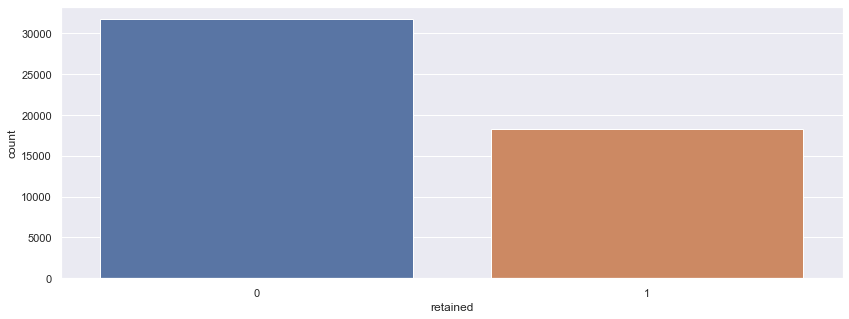

In [232]:
sns.countplot(x="retained", data=trips_cleaned)

In [233]:
trips_cleaned.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_month,last_trip_month,rider_tenure,retained
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,50000.00000
mean,2.278200,4.503842,1.074764,8.849536,0.37708,60.926084,5.796827,4.779050,1.0,4.042320,92.790100,0.36620
std,3.792684,0.606987,0.222336,19.958811,0.48466,37.081503,5.707357,0.445974,0.0,1.992879,62.129822,0.48177
min,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,0.00000
25%,0.000000,4.000000,1.000000,0.000000,0.00000,33.300000,2.420000,4.700000,1.0,2.000000,27.000000,0.00000
50%,1.000000,4.700000,1.000000,0.000000,0.00000,66.700000,3.880000,5.000000,1.0,5.000000,110.000000,0.00000
75%,3.000000,5.000000,1.050000,8.600000,1.00000,100.000000,6.940000,5.000000,1.0,6.000000,150.000000,1.00000
max,125.000000,5.000000,8.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.0,7.000000,181.000000,1.00000


In [234]:
#Retained proportion
retained = len(trips_cleaned[trips_cleaned['last_trip_date'] > '2014-06-01'])/len(trips_cleaned)
print('{:.0f}% of users were retained.'.format(retained*100))

37% of users were retained.


In [235]:
#trips_cleaned_pp=trips_cleaned.drop(['city','phone','signup_date',  'last_trip_date','ultimate_black_user'], axis=1)
#sns.pairplot(trips_cleaned_pp, hue ='retained')
##trips_cleaned_pp.head()
#plt.show()

In [ ]:
trips_numeric=trips_cleaned.drop(['city','phone','signup_date',  'last_trip_date','ultimate_black_user'], axis=1)
trips_numeric.corr()

In [236]:

#trips_numeric=trips_cleaned.drop(['city','phone','signup_date',  'last_trip_date','ultimate_black_user'], axis=1)
#
#sns.set(style="whitegrid")
#
#for i, col in enumerate(trips_numeric.columns):
#    plt.figure(i)
#    sns.boxplot(y=col,x="retained", data=trips_numeric, hue="retained")

Looked through boxplots of all numeric columns, the following three stood out.

<AxesSubplot:xlabel='retained', ylabel='trips_in_first_30_days'>

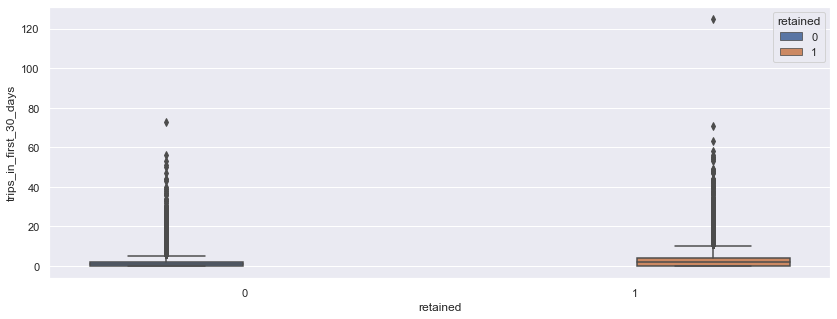

In [237]:
#plot surge percent
#proportion weekday driving
sns.boxplot(y="trips_in_first_30_days",x="retained", data=trips_cleaned, hue="retained")


<AxesSubplot:xlabel='retained', ylabel='weekday_pct'>

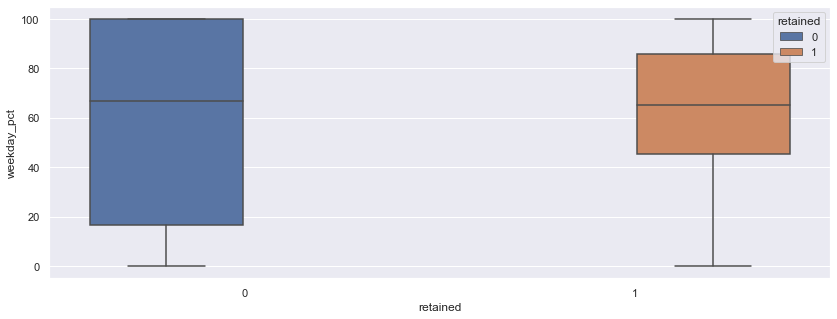

In [238]:
sns.boxplot(y="weekday_pct",x="retained", data=trips_cleaned, hue="retained")





# machine learning processing
  1. dummy variable for city
  2. dummy variable for phone. 

### One Hot Encode

In [247]:
# One-hot encode city and phone

trips_processing = trips_cleaned

trips_processing=pd.get_dummies(trips_processing, columns=['phone'], drop_first=True)
trips_processing=pd.get_dummies(trips_processing, columns=['city'], drop_first=True)

trips_processing=trips_processing.drop(['signup_month', 'last_trip_month', 'rider_tenure','signup_date', 'last_trip_date'], axis=1)


trips_processing.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,phone_iPhone,city_King's Landing,city_Winterfell
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,1,1,0
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,0,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,1,1,0
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1


In [249]:
trips_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int32  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   retained                50000 non-null  int32  
 9   phone_iPhone            50000 non-null  uint8  
 10  city_King's Landing     50000 non-null  uint8  
 11  city_Winterfell         50000 non-null  uint8  
dtypes: float64(6), int32(2), int64(1), uint8(3)
memory usage: 3.2 MB


### Scaling
Random Forest is a tree based algorithm so we don't need to rescale the predictors.

Distance-based algorithms that use euclidean ditances do need to consider scaling option.

# Test and Train designation

In [250]:
df=trips_processing

X = df.drop('retained', axis=1)
y = df['retained']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=125)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42500, 11)
(7500, 11)
(42500,)
(7500,)


In [241]:
df.shape

(50000, 12)

In [278]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_rf = clf.fit(X_train, y_train)

y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

true_neg=   cm[0,0]
false_neg=  cm[1,0]
true_pos=  cm[1,1]
false_pos=  cm[0,1]

# precision True positive rate
precision= true_pos/(false_pos+true_pos)

# Recall/ sensitivity
recall= true_pos/ (true_pos + false_neg)

print('Random Forest: Accuracy=%.3f' % (ac))
print( 'Random Forest: True pos rate/precision = %.2f' % (precision))
print('Random Forest: Recall=%.2f' % (recall))

print('Random Forest: f1-score=%.3f' % (f1))


Random Forest: Accuracy=0.765
Random Forest: True pos rate/precision = 0.68
Random Forest: Recall=0.68
Random Forest: f1-score=0.765


## Confusion Matrix


In [254]:
print(cm)

[[3874  880]
 [ 883 1863]]


The model has an overall accuracy of 76% in the test set. 37% of the users in the original data were retained after six omnths.  This is a large enough proportion that we don't need to be concerned with class imbalance.  Also, the error is less than this proportion in the training set so the model isn't simply guessing "retained".
The recall, precision, and f1 score help us understand the accuracy of a prediction within each class (retained/not retained).  In this case theses meausres are a little less than the overall accuracy.  The model appears to be doing a good job "out of the box".




### Feature Importance

11


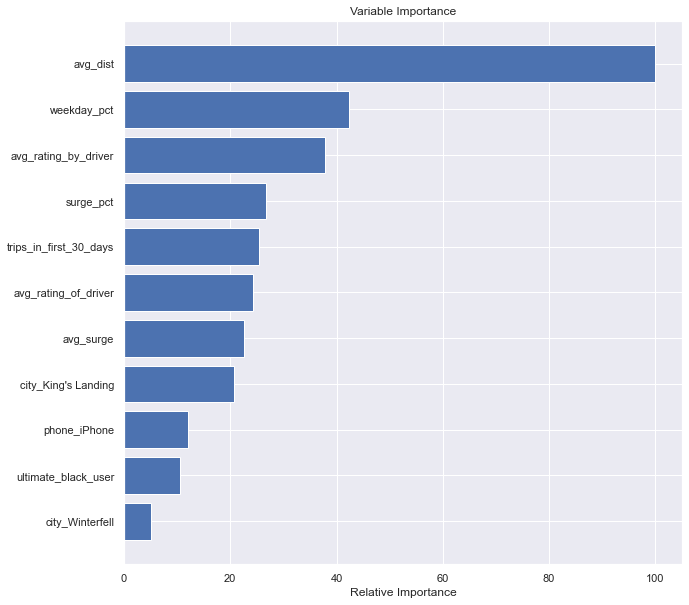

In [279]:
# feature importance plot

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Model Interpretation

Avg distance, weekday pct, and surge pct, and trips in the last 30 days are the most important features ifor predicting retention at siz months.

I hypothesize that there are three primary categories of drivers: those who use the app to supplement their income, those who use the app as a primary revenue source, and those who are casually using the app.  People could tranition between these categories with time but I suspect the people who are using it as a primary source of income are more commited.

Interetingly the rating by driver is more important than the driver's rating. This likely speaks to the quality of the driver's experience. If they are providing low ratings they aren't enjoying themselves and are more likely to transition off of the app or become more passive users.

Additional tools for interpretation would be Shapleys to plots to understand the directional importance of features on predicting retention after six months.

Based on the important features in predicting retention, if the company is inteerested in minimizing retention they should begin tracking driver satisfaction, managing the experiences of both the passenger and driver.



